In [1]:
from Bio import SearchIO
from Bio import SeqIO
from Bio import Phylo
from Bio.Seq import Seq
from Bio import AlignIO

from io import StringIO
import subprocess

from os import listdir
from os.path import isfile, join, dirname, isdir, exists
from os import path
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#These are the queries for the hmmsearch command. Change the genus or domain to your liking

genus = 'magnaporthe' #or try 'neurospora'
domain = 'NACHT' #try 'NACHT', 'NB-ARC', or 'HET'

In [93]:
#helper function for preparing directories. do not change this.

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath

In [4]:
#preparing path names for hmmsearch command...
proteome_path = make_path('proteomes', genus, os.listdir(make_dir('proteomes', genus))[0])
genomes_dir = make_dir('genomes', genus)
assembly_name = proteome_path.split('_')[-2]
domain_path = make_path('pfam_domains', domain+'.hmm')
hmmsearch_align_path = make_path('hmmsearch_align', genus, domain+'-'+assembly_name+'.aln')
hmmsearch_out_path = make_path('hmmsearch_out', genus, domain+'-'+assembly_name+'.out')
hmmmsearch_domout_path = make_path('hmmsearch_out', genus, domain+'-'+assembly_name+'.domout')

In [5]:
!hmmsearch --domE 0.01  -A $hmmsearch_align_path --domtblout $hmmmsearch_domout_path $domain_path $proteome_path > $hmmsearch_out_path

In [9]:
#Parse hmmsearch output and filter hits by e-value. Find these hits the reference proteome and display annotations of the numTop proteins along with their E-values

numTop = 15 ## change this to adjust the number of protein descriptions displayed
ethresh = 0.01 ### adjust this for e-value threshold

qresult = next(SearchIO.parse(hmmmsearch_domout_path, 'hmmsearch3-domtab'))
filtered_hits = list(filter(lambda hsp: hsp.evalue < ethresh, qresult.hsps))
hit_ids = [hsp.hit_id for hsp in filtered_hits]
hit_sequences = sorted([record for record in SeqIO.parse(proteome_path, "fasta") if record.id in hit_ids], key=lambda a: hit_ids.index(a.id))
print('\n'.join([f'E-value: {filtered_hits[ii].evalue} for ' + hit_sequences[ii].description for ii in range(numTop)]))

E-value: 2.3e-12 for XP_011393957.1 hypothetical protein NCU08537 [Neurospora crassa OR74A]
E-value: 2.3e-12 for XP_011393958.1 uncharacterized protein NCU08537 [Neurospora crassa OR74A]
E-value: 3.6e-10 for XP_959588.2 hypothetical protein NCU02194 [Neurospora crassa OR74A]
E-value: 1.7e-09 for XP_011393650.1 uncharacterized protein NCU09760 [Neurospora crassa OR74A]
E-value: 1.7e-09 for XP_011393649.1 hypothetical protein NCU09760 [Neurospora crassa OR74A]
E-value: 3.6e-09 for XP_962827.3 hypothetical protein NCU08565 [Neurospora crassa OR74A]
E-value: 2.5e-05 for XP_963877.1 peroxisome biosynthesis protein [Neurospora crassa OR74A]
E-value: 1.2e-08 for XP_011393432.1 NACHT domain-containing protein, variant [Neurospora crassa OR74A]
E-value: 9e-08 for XP_957922.2 hypothetical protein NCU04881 [Neurospora crassa OR74A]
E-value: 1.3e-08 for XP_011393433.1 NACHT domain-containing protein [Neurospora crassa OR74A]
E-value: 2.2e-07 for XP_011393626.1 hypothetical protein NCU08705 [Neuros

In [11]:
hit_sequences

[SeqRecord(seq=Seq('MADPATILGVFTGTLQIISFTRELISLTQEIAHTGSSDHDLKEKSEDLLDVSQN...REV'), id='XP_011393957.1', name='XP_011393957.1', description='XP_011393957.1 hypothetical protein NCU08537 [Neurospora crassa OR74A]', dbxrefs=[]),
 SeqRecord(seq=Seq('MADPATILGVFTGTLQIISFTRELISLTQEIAHTGSSDHDLKEKSEDLLDVSQN...REV'), id='XP_011393958.1', name='XP_011393958.1', description='XP_011393958.1 uncharacterized protein NCU08537 [Neurospora crassa OR74A]', dbxrefs=[]),
 SeqRecord(seq=Seq('MDPLSFTASLVAVVGLAGEVAKTCKSYIDGIKNHPREIRVIFIELTSLTSVLEG...VGS'), id='XP_959588.2', name='XP_959588.2', description='XP_959588.2 hypothetical protein NCU02194 [Neurospora crassa OR74A]', dbxrefs=[]),
 SeqRecord(seq=Seq('MPQAQRPDGFTRALAKFKQGLDPSLAQQFSISTLEDVRVLADKIQHEQGPQGKL...DLS'), id='XP_011393650.1', name='XP_011393650.1', description='XP_011393650.1 uncharacterized protein NCU09760 [Neurospora crassa OR74A]', dbxrefs=[]),
 SeqRecord(seq=Seq('MPQAQRPDGFTRALAKFKQGLDPSLAQQFSISTLEDVRVLADKIQHEQGPQGKL...DLS'), id='XP_0113

In [61]:
##Exonerates a protein to all genomes for the species. don't change this.
def exonerate(nlr_protein):    
    nlr_path = make_path('nlr_protein', genus, 'nlr_'+nlr_protein.id+'.fasta')
    p2gaa_path = make_path('exonerate_p2gaa', genus, 'p2gaa_%s.faa' % nlr_protein.id)
    p2gnt_path = make_path('exonerate_p2gnt', genus, 'p2gnt_%s.fasta' % nlr_protein.id)
    SeqIO.write(nlr_protein, nlr_path, "fasta")
    
    files = [f for f in listdir(genomes_dir) if isfile(join(genomes_dir, f)) and f != '.DS_Store' ]
    numExonerated = 0

    for ii, f in enumerate(files):
        proc = subprocess.run(['exonerate', '--model', 'protein2genome', '--bestn', '1', '--showvulgar', 'F', '--ryo', '''">%ti (%tab - %tae)\n%tas\n"''', nlr_path, join(genomes_dir, f)],  stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        outsplit = proc.stdout.decode().split('''"''')
        if len(outsplit) > 3:
#             print('exonerating', f, 'counter: ', ii)
            numExonerated += 1

            qresult = next(SearchIO.parse(StringIO(outsplit[-3]), 'exonerate-text'))
            aa_record = sum([frag.hit for frag in qresult[0][0]], Seq(''))

            if not ii:
                writeMode = 'w'
            else:
                writeMode = 'a'
            
            aafile = open(p2gaa_path, writeMode)        
            SeqIO.write(aa_record, aafile, 'fasta')
            aafile.close()

            ntfile = open(p2gnt_path, writeMode)        
            ntseq = outsplit[-2]
            ntfile.write(ntseq)
            ntfile.close()
            
#             if not ii % 50:
            print(ii+1, 'sequences exonerated')
#         else:
#             print('failed to exonerate', f, 'counter: ', ii)

    return numExonerated, ii+1


#get column of position weight matrix
def get_distr(aa_col, pseudocounts = 0.0):
    full_alphabet = 'ACDEFGHIKLMNPQRSTVWY-X*'
    abundict = {aa:pseudocounts for aa in list('ACDEFGHIKLMNPQRSTVWY')}
    for site in aa_col:
        if site in abundict.keys():
            abundict[site] += 1.0
#         else:
#             print('did not find', site, 'in alphabet')
#             raise Exception()
    abundict = {aa:count for aa,count in abundict.items() if count > 0.0}
    weights = np.array(list(abundict.values()))
    distr = weights/sum(weights)
    return distr

#compute entropy from a list of weights
def get_entropy(distr):
    return -np.sum(np.log(distr)*distr)

#returns entropy sequence from multiple alignment
def get_entropy_sequence(align):
    entropies = []
    for col in range(len(align[0,:])):
        entropies.append(get_entropy(get_distr(align[:, col])))
    return np.array(entropies)

#plot entropy sequence
def plot_entropy(entropies, protein_id):
    plt.plot(entropies)
    plt.xlabel('Amino acid position')
    plt.ylabel('Bits')
    plt.ylim(0, 2)
    plt.title('Entropy plot for %s' % protein_id)
    
    
# def save_plot(nlr_protein):    
#     entropy_seq_path = make_path('entropy', genus, 'seq', 'entropy_clustalo_%s.npy' % nlr_protein.id)
#     plot_entropy(np.load(entropy_seq_path), nlr_protein.id)
#     entropy_plot_path = make_path('entropy', genus, 'plot', 'entropy_clustalo_%s.png' % nlr_protein.id)
#     plt.savefig(entropy_plot_path)    
    
def get_multiple_alignment(nlr_protein):
    print('exonerating protein', nlr_protein.id, '...')
    numExonerated, numGenomes = exonerate(nlr_protein)
    print(numExonerated, 'genomes out of', numGenomes, 'total contain an ortholog of protein', nlr_protein)
    
    p2gaa_path = make_path('exonerate_p2gaa', genus, 'p2gaa_%s.faa' % nlr_protein.id)
    clustalo_out_path = make_path('clustalo_out', genus, 'clustalo_%s.out' % nlr_protein.id)
    !clustalo -i $p2gaa_path -o $clustalo_out_path
    
def save_entropy(nlr_protein):
    clustalo_out_path = make_path('clustalo_out', genus, 'clustalo_%s.out' % nlr_protein.id)
    entropies = get_entropy_sequence(AlignIO.read(clustalo_out_path, "fasta"))
    entropy_seq_path = make_path('entropy', genus, 'seq', 'entropy_clustalo_%s.npy' % nlr_protein.id)    
    np.save(entropy_seq_path, entropies)
    entropy_plot_path = make_path('entropy', genus, 'plot', 'entropy_clustalo_%s.png' % nlr_protein.id)
    plot_entropy(entropies, nlr_protein.id)
    plt.savefig(entropy_plot_path)
    plt.close()

def main(nlr_protein):
    get_multiple_alignment(nlr_protein)
    save_entropy(nlr_protein)
    
def loop_over_hits(hits):
    for nlr_protein in hits:
        main(nlr_protein)
        print('completed pipeline on protein', nlr_protein.id)
    


In [95]:
# use the main function to exonerate a protein against the genomes,
# compute multiple alignment, and save entropy plots
# also try loop_over_hits(hit_sequences) to run the pipeline on
# a list hit sequences found by hmmer

main(hit_sequences[3])

exonerating protein XP_011393650.1 ...
1 sequences exonerated
2 sequences exonerated
3 sequences exonerated
4 sequences exonerated
5 sequences exonerated
6 sequences exonerated
6 genomes out of 6 total contain an ortholog of protein ID: XP_011393650.1
Name: XP_011393650.1
Description: XP_011393650.1 uncharacterized protein NCU09760 [Neurospora crassa OR74A]
Number of features: 0
Seq('MPQAQRPDGFTRALAKFKQGLDPSLAQQFSISTLEDVRVLADKIQHEQGPQGKL...DLS')
FATAL: Cowardly refusing to overwrite already existing file 'clustalo_out/neurospora/clustalo_XP_011393650.1.out'. Use --force to force overwriting.


In [ ]:
for nlr_protein in hit_sequences:
    save_entropy(nlr_protein)
    print('saved entropy on protein', nlr_protein.id)

Text(0.5, 1.0, 'Entropy plot for XP_003712653.1')

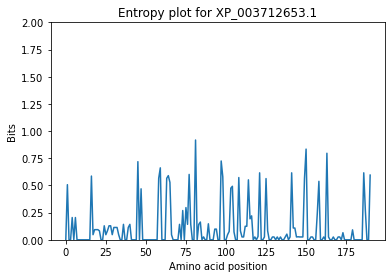

In [14]:
import matplotlib.pyplot as plt
import numpy as np

entropies = np.load('entropy/magnaporthe/seq/entropy_clustalo_XP_003711083.1.npy')

plt.plot(entropies[934:1125])
plt.xlabel('Amino acid position')
plt.ylabel('Bits')
plt.ylim(0, 2)
plt.title('Entropy plot for %s' % 'XP_003712653.1')